In [3]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import gseapy as gp
import scanpy as sc

In [7]:
adata=sc.read('/data/work/final/03_anno/Osteoblast/Osteoblast.h5ad')
import numpy as np

# 保留 'macrophage/monocyte'，其余设为 'other'
adata.obs['gsea'] = np.where(
    adata.obs['stage1'] == 'early',  # 条件
    'early',                       # 满足条件时的值
    'other'                                      # 不满足时的值
)
adata.obs.groupby('leiden_res0.6')['gsea'].value_counts()
adata.obs['gsea'] = pd.Categorical(adata.obs['gsea'], categories=["early", "other"], ordered=True)
indices = adata.obs.sort_values(['annotation1', 'gsea']).index
adata = adata[indices,:]


top_svgs = adata.var_names[adata.var["highly_variable"]].tolist()
downsample_idx = np.random.choice(adata.obs.index, size=2000, replace=False)
adata = adata[downsample_idx, top_svgs].copy()


In [8]:
import time
t1 = time.time()
# NOTE: To speed up, use gp.prerank instead with your own ranked list.
res = gp.gsea(data=adata.to_df().T, # row -> genes, column-> samples
        gene_sets="GO_Biological_Process_2021",
        cls=adata.obs.gsea,
        permutation_num=1000,
        permutation_type='phenotype',
        outdir=None,
        method='s2n', # signal_to_noise
        threads= 16)
t2=time.time()
print(t2-t1)

16.736238956451416


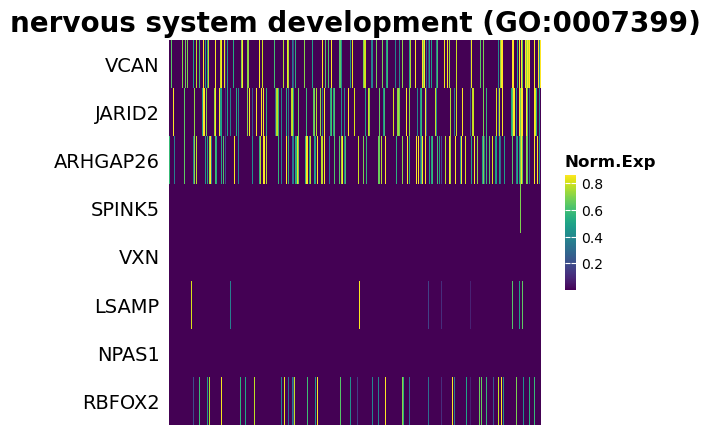

In [10]:
i = 7
genes = res.res2d.Lead_genes.iloc[i].split(";")
ax = gp.heatmap(df = res.heatmat.loc[genes],
           z_score=None,
           title=res.res2d.Term.iloc[i],
           figsize=(6,5),
           cmap=plt.cm.viridis,
           xticklabels=False)

In [14]:
term = res.res2d.Term
# gp.gseaplot(res.ranking, term=term[i], **res.results[term[i]])
axs = res.plot(terms=term[:5])

AttributeError: 'GSEA' object has no attribute 'plot'

In [18]:
adata.uns['log1p']['base']=None

In [16]:
# find degs
sc.tl.rank_genes_groups(adata,
                        groupby='stage1',
                        use_raw=False,
                        method='wilcoxon',
                        groups=["early"],
                        reference='late')

KeyError: 'base'

In [17]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

KeyError: 'names'

In [ ]:
# get deg result
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [ ]:
pre_res = gp.prerank(degs.loc[:,['STIM_names', 'STIM_logfoldchanges']], gene_sets='KEGG_2016')
term2 = pre_res.res2d.Term
axes = pre_res.plot(terms=term2[:5])

In [15]:
print('finish')

finish
